# Apply 3D LUT differentiable
As we can't just use the `ImageFilter` method of the python image library for our training as it is not differentiable, we have to find another way to apply a 3D LUT to an image. \
In this notebook we will explain the functions we came up with.

PIL ImageFilter Module: https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html

In [1]:
from pillow_lut import identity_table, rgb_color_enhance
from PIL import Image, ImageFilter
from IPython.display import display
import pandas as pd
import numpy as np
from torchvision import transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Creation of test LUTs
We create three example LUTs based on the code we created in the introduction of the 3D LUT, where we created a LUT to edit an image into a red toned version. \
Here we do the same for red, green and blue to be able to test our application functions.

In [2]:
identity_lut_8bit = identity_table(8)

In [3]:
red_toned_8bit_LUT = []
for rgb_values in identity_lut_8bit.table.reshape(-1,3):
    red = sum(rgb_values)/3
    output = [red,0,0]
    red_toned_8bit_LUT.append(output)

In [4]:
green_toned_8bit_LUT = []
for rgb_values in identity_lut_8bit.table.reshape(-1,3):
    green = sum(rgb_values)/3
    output = [0,green,0]
    green_toned_8bit_LUT.append(output)

In [5]:
blue_toned_8bit_LUT = []
for rgb_values in identity_lut_8bit.table.reshape(-1,3):
    blue = sum(rgb_values)/3
    output = [0,0,blue]
    blue_toned_8bit_LUT.append(output)

In [6]:
red_toned_8bit_LUT=np.array(red_toned_8bit_LUT, dtype="float32")
green_toned_8bit_LUT=np.array(green_toned_8bit_LUT, dtype="float32")
blue_toned_8bit_LUT=np.array(blue_toned_8bit_LUT, dtype="float32")

In [7]:
lut1 = torch.from_numpy(red_toned_8bit_LUT.reshape(8, 8, 8, 3))
lut2 = torch.from_numpy(green_toned_8bit_LUT.reshape(8, 8, 8, 3))
lut3 = torch.from_numpy(blue_toned_8bit_LUT.reshape(8, 8, 8, 3))

In [8]:
luts = torch.stack([lut1,lut2,lut3], dim=0)
luts.shape

torch.Size([3, 8, 8, 8, 3])

## Load test image
We load a test image from our training data and create a tensor that contains it three times to match the length of our lut tensor.

In [9]:
transform = transforms.Compose([transforms.ToTensor()])

In [10]:
image = transform(Image.open("../../fuji_images/JPG/256x256/DSCF2607.JPG")).unsqueeze(0)

In [11]:
image.shape

torch.Size([1, 3, 256, 256])

In [12]:
images = image.repeat(3,1,1,1)

In [13]:
images.shape

torch.Size([3, 3, 256, 256])

## Application functions
The first function we created, called `simple_approach`, applies a tensor of `luts` on the given `images` without any interpolation. \
As we explained in the previous Notebook LUTs would require a size of 256x256x256x3 to map all colors to new values, but usually are a lot smaller than that.

Therefore, in a first step we multiply the images RGB values (that are in range 0 to 1) by the LUT size (minus 1, as 0 is also an index) and round them to an integer / long value. \
That way the `image_normalized` would have only RGB values in range 0 to 7 for a 8 bit LUT.

Due to this operation we can than apply the LUT, as by now we can map every color to a new value, as the `image_normalized` do only contain values that are represented in our `luts`.

In [14]:
def simple_approach(luts, images):
    # Verify correct shape of LUTs
    lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
    # Transform images to have Values in range of the LUT size and round themsqueeze(
    image_normalized = (images * (luts.shape[2] - 1)).long()
    # Ensure that the values do not exceed the range
    image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
        
    r = image_normalized[:, 0, :, :]
    g = image_normalized[:, 1, :, :]
    b = image_normalized[:, 2, :, :]

    # Apply LUT transformation
    transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
    # Return expected shape
    transformed = transformed.permute(0, 3, 1, 2)

    return transformed

The second approach was the `slow_trilinear_interpolation` that uses for loops to perform trilinear interpolation as presented in https://spie.org/samples/PM159.pdf. \
It calculates the trilinear interpolation for every channel in an image of the batch and is therefore comparetively inefficient.

In [15]:
def slow_trilinear_interpolation(luts, images):
    batch_size, channels, height, width = images.shape
    lut_size = luts.shape[1]
    
    # Create coordinate grid for interpolation
    grid_x = images * (lut_size - 1)
    
    # Compute interpolation coordinates
    x0 = grid_x.floor().long()
    x1 = (x0 + 1).clamp(max=lut_size - 1)
    
    # Compute interpolation weights
    wx = grid_x - x0.float()
    
    # Prepare output tensor
    output = torch.zeros_like(images, dtype=torch.float32)
    
    # Iterate through batch
    for b in range(batch_size):
        for c in range(channels):
            # Sample LUT values
            c000 = luts[b, x0[b,c], x0[b,c], x0[b,c], c]
            c100 = luts[b, x1[b,c], x0[b,c], x0[b,c], c]
            c010 = luts[b, x0[b,c], x1[b,c], x0[b,c], c]
            c110 = luts[b, x1[b,c], x1[b,c], x0[b,c], c]
            c001 = luts[b, x0[b,c], x0[b,c], x1[b,c], c]
            c101 = luts[b, x1[b,c], x0[b,c], x1[b,c], c]
            c011 = luts[b, x0[b,c], x1[b,c], x1[b,c], c]
            c111 = luts[b, x1[b,c], x1[b,c], x1[b,c], c]
            
            # Trilinear interpolation
            c00 = c000 * (1 - wx[b,c]) + c100 * wx[b,c]
            c01 = c001 * (1 - wx[b,c]) + c101 * wx[b,c]
            c10 = c010 * (1 - wx[b,c]) + c110 * wx[b,c]
            c11 = c011 * (1 - wx[b,c]) + c111 * wx[b,c]
            
            c0 = c00 * (1 - wx[b,c]) + c10 * wx[b,c]
            c1 = c01 * (1 - wx[b,c]) + c11 * wx[b,c]
            
            output[b,c] = c0 * (1 - wx[b,c]) + c1 * wx[b,c]
    
    return output

Thanks to an issue in a repository that also works with 3D LUTs in the context of machine learning we got the idea to use the `torch.nn.functional.grid_sample` to apply the `luts` to our images.
Based on this function we build the `trilinear_interpolation` method below. First of all we scale the images as required by the function:
> "*grid specifies the sampling pixel locations normalized by the input spatial dimensions. Therefore, it should have most values in the range of [-1, 1]*"

Then we have to reshape the tensors to match the requirements from `grid_sample` with an expected input shape of (N,C,Din​,Hin​,Win​).
N is the batch size, C the channels, D are the dimensions and H and W the height and width.

Even tough we seem to specify the mode `bilinear` it uses trilinear interpolation on our 5D input:
> "*When mode='bilinear' and the input is 5-D, the interpolation mode used internally will actually be trilinear.*"

Source: https://github.com/HuiZeng/Image-Adaptive-3DLUT/issues/14 \
Grid sample method: https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html

In [16]:
def trilinear_interpolation(luts, images):
    # Scale images to be between -1 and 1
    img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]

    # Add a singleton dimension to represent "channel" for LUT interpolation
    img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]

    # Ensure LUT is in the correct format
    LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]

    # Perform grid sampling for each channel
    result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]

    # Remove the singleton dimension and permute to the correct format
    result = result.squeeze(2)  # Remove the extra "depth" dimension - Shape: [4, 3, 256, 256]

    return result

## Comparison and testing
To verify that our functions apply the LUTs correctly we applied them to our test image.

In [17]:
simple_edited_images = simple_approach(luts, images)

In [18]:
slow_edited_images = slow_trilinear_interpolation(luts, images)

In [19]:
trilinear_edited_images = trilinear_interpolation(luts, images)

In [20]:
def display_images(images, titles=None):
    # Three subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))
    
    # Convert and display each image
    for idx, (ax, img) in enumerate(zip(axes, [images[0], images[1], images[2]])):
        # Convert tensor to numpy array
        tensor_image = img.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        
        # Display the image
        ax.imshow(image_np)
        ax.axis('off')
        
        # Set title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

### Test the processing of our test images and luts
As we can see below all functions transform the images to red, green and blue toned versions as expected. \
There is a slight variation in color which could be due to the different calculation and application methods used as the 8-bit LUT we used in this test is quite small.

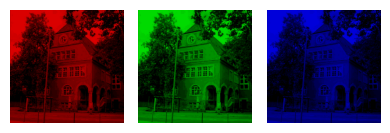

In [21]:
display_images(simple_edited_images)

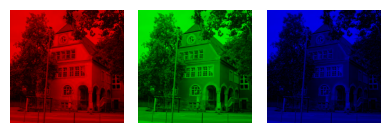

In [22]:
display_images(slow_edited_images)

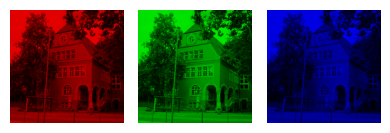

In [23]:
display_images(trilinear_edited_images)

### Test the processing time for a batch of 1000 images and LUTs
In the next step we test the processing time of the three functions with a batch of 1000 images and LUTs. We simply use random images and luts as this should not be playing a role for this comparison. \
We perform the operation ten times.

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
import time
start_time = time.time()

for i in range(10):
    test_apply_images = simple_approach(torch.rand(1000, 33, 33, 33, 3).to(device), torch.rand(1000, 3, 256, 256).to(device))

end_time = time.time()
elapsed_time_simple = end_time - start_time

In [26]:
import time
start_time = time.time()

for i in range(10):
    test_apply_images = slow_trilinear_interpolation(torch.rand(1000, 33, 33, 33, 3).to(device), torch.rand(1000, 3, 256, 256).to(device))

end_time = time.time()
elapsed_time_slow = end_time - start_time

In [27]:
import time
start_time = time.time()

for i in range(10):
    test_apply_images = trilinear_interpolation(torch.rand(1000, 33, 33, 33, 3).to(device), torch.rand(1000, 3, 256, 256).to(device))

end_time = time.time()
elapsed_time_trilinear = end_time - start_time

In [28]:
print(elapsed_time_simple, elapsed_time_slow, elapsed_time_trilinear)

19.470306634902954 50.775174379348755 19.131083965301514


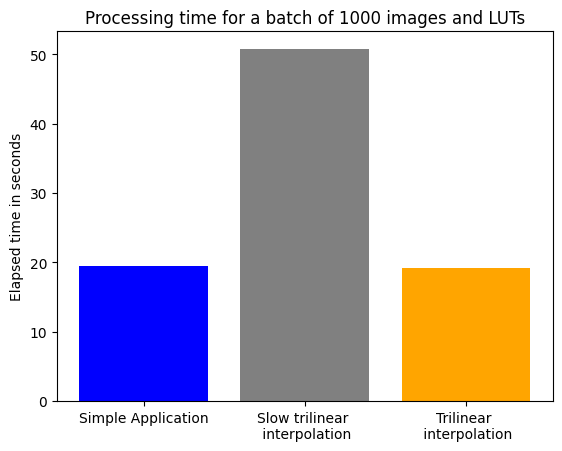

In [29]:
labels = ['Simple Application', 'Slow trilinear \n interpolation', 'Trilinear \n interpolation']
values = [elapsed_time_simple, elapsed_time_slow, elapsed_time_trilinear]

plt.bar(labels, values, color=['blue', 'gray', 'orange'])

# Add labels and title
plt.ylabel('Elapsed time in seconds')
plt.title('Processing time for a batch of 1000 images and LUTs')

plt.show()

## Conclusion
As we can see above the trilinear interpolation relying on for loops takes about 1.5x as much time as the simple application. We would expect that this difference would even be greater with larger tensors and in training as the iteration becomes very inefficient then. The trilinear interpolation relying on the `torch.nn.functional.grid_sample` is the fastest and takes less time than the simple application (even though it uses the computationally more complex trilinear interpolation). 
At this point it seems like this the best option to be used to apply 3D luts to images in training. 